In [1]:
#test to see if this goes on Emily's branch AND Reid's branch or just Reid's branch

## Data Analysis and Cleaning

In [22]:
#all required imports
import pandas as pd
import sqlite3
import numpy as np
import gzip
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [4]:
#Data files extracting
FP1 = 'zippedData/rt.reviews.tsv.gz' #rotten tomatoes - no movie titles? where to get?
FP2 = 'zippedData/rt.movie_info.tsv.gz' #rotten tomatoes - no movie titles? where to get?
FP3 = 'zippedData/bom.movie_gross.csv.gz' #box office mojo studio and revenues / budgets for films - connect to other DB? This one vs. TN?
FP4 = 'zippedData/tmdb.movies.csv.gz' #the movies database - has vote counts and vote averages from the people vs. critics
FP5 = 'zippedData/tn.movie_budgets.csv.gz' #finanial data
#FP6 = 

#rotten tomatoes reviews file to pd_dataframe
with gzip.open(FP1, 'rt') as f1:
    rt_review = pd.read_csv(f1, delimiter='\t')

#rotten tomatoes info file to pd_dataframe   
with gzip.open(FP2, 'rt') as f2:
    rt_info = pd.read_csv(f2, delimiter='\t')    

#box office mojo file to pd_dataframe
with gzip.open(FP3, 'rt') as f3:
    bom_df = pd.read_csv(f3)

#The Movie DB file to pd_dataframe
with gzip.open(FP4, 'rt', encoding='utf-8') as f4:
    tmdb_df = pd.read_csv(f4, index_col='Unnamed: 0') #there is a column that holds the index value, setting as index
    
#The Numbers file to pd_dataframe
with gzip.open(FP5, 'rt', encoding='utf-8') as f5:
    tn_df = pd.read_csv(f5)
    

    
#merging the two rotten tomatoes databases together for analysis
total_rt = pd.merge(rt_info, rt_review, on='id', how='outer')

#IMDb file to SQL connection
zip_file_path = 'zippedData/im.db.zip'
extracted_db_path = 'im.db'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_db_path)
    
conn = sqlite3.connect("im.db/im.db")
cur = conn.cursor()

## Reviewing the Dataframes

In [5]:
#reviewing the size of the data:

print('rotten tomatoes reviews: '+str(rt_review.shape))
print('rotten tomatoes info: '+str(rt_info.shape))
print('Box Office Mojo: '+str(bom_df.shape))
print('TMDb reviews: '+str(tmdb_df.shape))
print('TN DB reviews: '+str(tn_df.shape))


rotten tomatoes reviews: (54432, 8)
rotten tomatoes info: (1560, 12)
Box Office Mojo: (3387, 5)
TMDb reviews: (26517, 9)
TN DB reviews: (5782, 6)


In [6]:
#starting with The Numbers Database:
tn_df.dtypes

id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object

In [7]:
#cleaning tn_df for financial data, time-series data, and creating a profit column

tn_df['domestic_gross'] = tn_df['domestic_gross'].astype(str).str.replace(',','')
tn_df['domestic_gross'] = tn_df['domestic_gross'].astype(str).str.replace('$','')
tn_df['production_budget'] = tn_df['production_budget'].astype(str).str.replace(',','')
tn_df['production_budget'] = tn_df['production_budget'].astype(str).str.replace('$','')
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].astype(str).str.replace(',','')
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].astype(str).str.replace('$','')

tn_df['domestic_gross'] = pd.to_numeric(tn_df['domestic_gross'], downcast = 'integer')
tn_df['production_budget'] = pd.to_numeric(tn_df['production_budget'], downcast = 'integer')
tn_df['worldwide_gross'] = pd.to_numeric(tn_df['worldwide_gross'], downcast = 'integer')

tn_df['release_date'] = pd.to_datetime(tn_df['release_date'])
tn_df['release_month'] = tn_df['release_date'].dt.month

tn_df['profit'] = tn_df['worldwide_gross'] - tn_df['production_budget']

In [8]:
tn_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_month,profit
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,12,2351345279
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,5,635063875
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,6,-200237650
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,5,1072413963
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,12,999721747
...,...,...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000,0,0,12,-7000
5778,79,1999-04-02,Following,6000,48482,240495,4,234495
5779,80,2005-07-13,Return to the Land of Wonders,5000,1338,1338,7,-3662
5780,81,2015-09-29,A Plague So Pleasant,1400,0,0,9,-1400


In [9]:
#Reviewing The Movies Database - to be merged with The Numbers database
tmdb_df

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...
26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [10]:
tmdb_columns = ['title', 'popularity', 'vote_average', 'vote_count']

# Merge the DataFrames
merged_df = pd.merge(tn_df, tmdb_df[tmdb_columns], left_on='movie', right_on='title', how='inner')

# Drop the 'title' column from merged_df bc we are keeping the 'movie' column
merged_df.drop('title', axis=1, inplace=True)

# Display the merged DataFrame
merged_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_month,profit,popularity,vote_average,vote_count
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,12,2351345279,26.526,7.4,18676
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,5,635063875,30.579,6.4,8571
2,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,5,1072413963,44.383,7.3,13457
3,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,4,1748134200,80.773,8.3,13948
4,9,2017-11-17,Justice League,300000000,229024295,655945209,11,355945209,34.953,6.2,7510


In [11]:
merged_df.rename(columns={'vote_average': 'TMDb_rating', 'vote_count': 'TMDb_vote_count', 'popularity': 'TMDb_popularity'}, inplace=True)

In [18]:
merged_df.shape

(2385, 11)

### Rotten Tomatoes Database - combined

In [98]:
total_rt.head()

,id,synopsis,rating_x,genre,director,writer,theater_date,dvd_date,currency,box_office,...,review,rating_y,fresh,critic,top_critic,publisher,date,timespan,box_rev,Numeric_rating
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,1971-10-09,2001-09-25,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,10944.0,NaN,None
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,2013-01-01,$,"600,000",...,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0.0,Patrick Nabarro,2018-11-10,137.0,600000.0,0.6
2,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,2013-01-01,$,"600,000",...,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0.0,io9.com,2018-05-23,137.0,600000.0,None
3,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,2013-01-01,$,"600,000",...,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0.0,Stream on Demand,2018-01-04,137.0,600000.0,None
4,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,2013-01-01,$,"600,000",...,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0.0,MUBI,2017-11-16,137.0,600000.0,None


In [13]:
total_rt.columns

Index(['id', 'synopsis', 'rating_x', 'genre', 'director', 'writer',
       'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime',
       'studio', 'review', 'rating_y', 'fresh', 'critic', 'top_critic',
       'publisher', 'date'],
      dtype='object')

In [14]:
#cleaning the runtime column
total_rt['runtime'] = total_rt['runtime'].replace(to_replace=' minutes', value='', regex=True)
total_rt['runtime'] = pd.to_numeric(total_rt['runtime'], downcast = 'integer')

#converting date columns to date-time format
total_rt['theater_date'] = pd.to_datetime(total_rt['theater_date'])
total_rt['dvd_date'] = pd.to_datetime(total_rt['dvd_date'])
total_rt['date'] = pd.to_datetime(total_rt['date'])

#creating time length in theaters
total_rt['timespan'] = (total_rt['dvd_date'] - total_rt['theater_date']).dt.days

#converting box office revenue to an integer
total_rt['box_rev'] = total_rt['box_office'].replace(to_replace=',', value='', regex=True)
total_rt['box_rev'] = pd.to_numeric(total_rt['box_rev'], downcast = 'integer')

In [15]:
total_rt['runtime'].value_counts()

115.0    2082
108.0    2030
95.0     1803
119.0    1720
98.0     1456
         ... 
5.0         1
13.0        1
152.0       1
195.0       1
15.0        1
Name: runtime, Length: 142, dtype: int64

In [51]:
print(total_rt['rating_y'][1])
type(total_rt['rating_y'][1])

3/5


str

In [52]:
#cleaning the ratings column
#step 1. taking letter grades and applying fraction out of 15 (A-F + and -)
grades = {
    'A+': 15/15,
    'A': 14/15,
    'A-': 13/15,
    'B+': 12/15,
    'B': 11/15,
    'B-': 10/15,
    'C+': 9/15,
    'C': 8/15,
    'C-': 7/15,
    'D+': 6/15,
    'D': 5/15,
    'D-': 4/15,
    'F+': 3/15,
    'F': 2/15,
    'F-': 1/15
}

# Function to convert fractions to decimals
def frac_to_decimal(frac_str):
    try:
        numerator, denominator = map(float, frac_str.split('/'))
        if denominator == 0:
            return None  # Handle division by zero
        return numerator / denominator
    except ValueError:
        return None  # Handle invalid fraction format

# Apply the conversion function to the 'Fraction' column
#df['Decimal'] = df['Fraction'].apply(frac_to_decimal)

#creating new numeric rating column
total_rt['Numeric_rating'] = None

for index, row in total_rt.iterrows():
    rating = row['rating_y']
    if rating in grades:
        numeric_rating = grades[rating]
        total_rt.at[index, 'Numeric_rating'] = numeric_rating
    elif '/' in str(rating): #I think this is going to break the code?
        try:
            numeric_value = frac_to_decimal(rating)
            total_rt.at[index, 'Numeric_rating'] = numeric_value
        except ValueError:
            pass  # skip non-fraction rated rows   
    else:
        continue    
    

In [58]:
total_rt['Numeric_rating'][1]# = pd.to_numeric(total_rt['rating_y'], downcast = 'float')

0.6

### Data is cleaned, now for questions to be answered:

    - Genre vs. binned profitability - chi-squared test?
    - do writers who also produce have better profitability compared to separate writers and directors - T-test
    

In [ ]:
Writers who also direct - does that affect ratings?


### Visualizations draft

In [20]:
merged_df.columns

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'release_month', 'profit', 'TMDb_popularity',
       'TMDb_rating', 'TMDb_vote_count'],
      dtype='object')

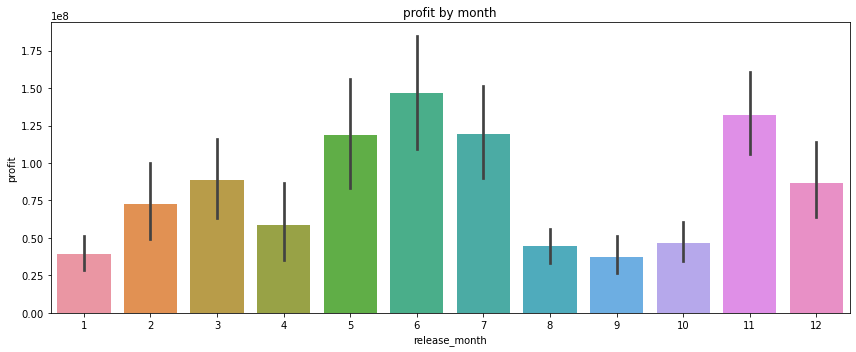

In [28]:
#best time to release a movie
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

#plot first bar chart
sns.barplot(x=merged_df['release_month'], y=merged_df['profit'])
ax.set_title('Profit by Month')

#plot second
#sns.barplot(x=merged_df.release_month, y=merged_df.profit, ax=[0,2])
#axes[1].set_title('Profit by Genre')

plt.tight_layout()
plt.show();

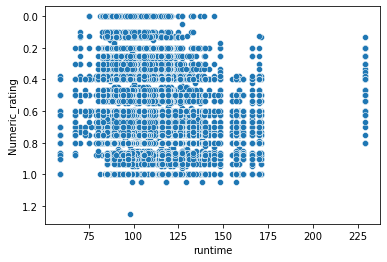

In [71]:
corr_df = total_rt[total_rt['timespan'] < (72*7)]
x = corr_df['timespan'].corr(corr_df['runtime'])
x
#Jurassic park was the film with longest box office time per BOM


sns.scatterplot(x=corr_df['runtime'], y=corr_df['Numeric_rating']);

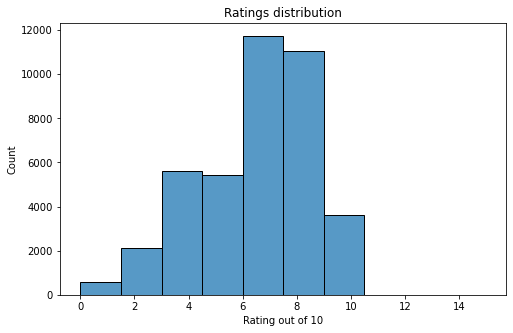

In [96]:
x = total_rt[total_rt['Numeric_rating'].notna()]['Numeric_rating'].apply(lambda x: x*10)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.histplot(data=x, bins = 10)
ax.set_title('Ratings distribution')
ax.set_xlabel('Rating out of 10');

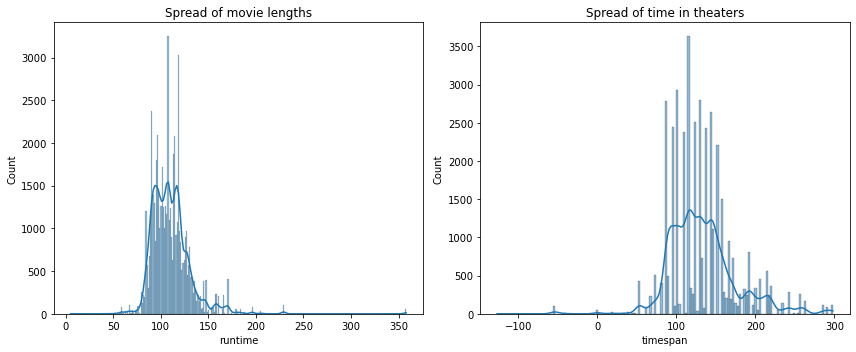

In [23]:
#is there anything to compare movie lengths to

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#plot first histogram
sns.histplot(data=total_rt['runtime'], kde=True, ax=axes[0])
axes[0].set_title('Spread of movie lengths')

#plot second
sns.histplot(data=total_rt[total_rt['timespan'] <300]['timespan'], kde=True, ax=axes[1])
axes[1].set_title('Spread of time in theaters')

plt.tight_layout()
plt.show();

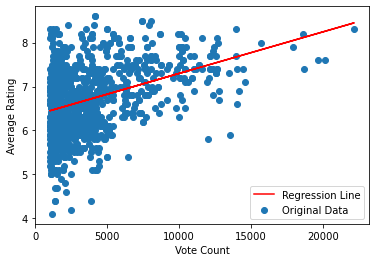

In [176]:
model = LinearRegression()
reg_df = tmdb_df[tmdb_df['vote_count'] > 1000]
X = reg_df[['vote_count']]
Y = reg_df['vote_average']
model.fit(X, Y)
intercept = model.intercept_
slope = model.coef_[0]

Y_pred = model.predict(X)

plt.scatter(X, Y, label='Original Data')
plt.plot(X, Y_pred, color='red', label='Regression Line')
plt.xlabel('Vote Count')
plt.ylabel('Average Rating')
plt.legend()
plt.show()

## Reading and analyzing the SQL Database from IMDb

In [31]:
#examining the tables within the IMDb SQL database
df = pd.read_sql(
    """
    SELECT *
    FROM sqlite_master
    """
, conn
)

df[df['type'] == 'table']

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [22]:
pd.read_sql("""
    SELECT *
    FROM movie_basics
    JOIN movie_ratings
        USING (movie_id)
    JOIN known_for
        USING (movie_id)
    LIMIT 10
    --WHERE start_year = 2013

""", conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,person_id
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,nm1194313
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,nm1391276
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,nm0000953
3,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,nm0462648
4,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,nm0600800
5,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,nm0613657
6,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,nm0869470
7,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,nm0919912
8,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,nm1152466
9,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,nm1475059


In [30]:
pd.read_sql("""
    SELECT primary_title, primary_name
    FROM persons
    JOIN known_for
        USING (person_id)
    JOIN movie_basics
        USING (movie_id)
    LIMIT 30
    --ORDER BY primary_title DESC

""", conn)

,primary_title,primary_name
0,Hotel Transylvania,Mary Ellen Bauder
1,Smurfs: The Lost Village,Mary Ellen Bauder
2,Playback,Joseph Bauer
3,Totem,Joseph Bauer
4,Racing Extinction,Axel Baumann
5,Mission Blue,Axel Baumann
6,The Rocket,Pete Baxter
7,No Other Woman,Ruel S. Bayani
8,One More Try,Ruel S. Bayani
9,Five Heroes Get Together,Bayou
